# Introduction

Last tested version: <img src="https://img.shields.io/badge/Atoti-v0.9.4-blue">

In this notebook we will illustrate how to create a Monte Carlo aggregation engine using Atoti Python interface. 

With this application we will be able to interactively recompute xVA measures and explore risk drivers via pivot tables and charts, and manipulate the inputs to calculate incremental contributios and what-if scenarios.

## Where Atoti fits?

An xVA platform typically relies on several building blocks - starting with portfolio and market data, with simulation engine in the heart of the model and risk&valuation system - that generate future exposure/capital/margin/etc profiles.

The size of Monte Carlo data sets can be significant. For example, credit exposure profiles for a portfolio with 100.000 trades, 1000 scenarios and 100 future dates - will total in $10^9$ values - which would need to be aggregated to obtain the desired xVA metric. 

We will use Atoti store Monte Carlo data set in-memory and aggregate it interactively. Thanks to native support of vectorized data and simple API, the desired aggregation/netting rules can be defined easily. Once the aggregation logic is described, we'll be able to slice and dice/filter and recompute xVA interactively in the UI to verify the numbers and identify drivers. 

In addition to efficient big data aggregation, Atoti will enable real-time xVA recalculation, should new simulations arrive into the aggregation engine. This is thanks to the built-in "what-if" functionality.

<img src = "atoti-in-the-xva-platform.png"></img>


Typically xVA models are simulation-based. Let's consider different xVA methodologies: 

- CVA/DVA/FVA calculation involves integration over time of the expected **exposure profiles** or expected future values,
- KVA calculation will aggregate **capital profiles** data,
- ColVA will be based on simulated **collateral balances**,
- MVA requires a distribution of future **IM amounts**.

In this notebook we illustrate how to configure Monte Carlo aggregation using Atoti Python interface for a CVA example. 


<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=github-xva" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

# Imports

In [1]:
import os
from zipfile import ZipFile

import numpy as np
import pandas as pd
import wget
from IPython.display import clear_output, display

# Before we start - loading sample data from s3

In [2]:
# !conda install -c conda-forge python-wget -y

In [3]:
def bar_custom(current, total, width=80):
    clear_output(wait=True)
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))

In [4]:
for f in ["data.zip", "data-prev.zip", "what-if.zip"]:
    filename = wget.download("http://data.atoti.io/notebooks/xva/" + f, bar=bar_custom)

for item in os.listdir("."):
    if item.endswith("zip"):
        file_name = os.path.abspath(item)
        with ZipFile(file_name, "r") as zipObj:
            # Extract all the contents of zip file in current directory
            zipObj.extractall()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



# Launching Atoti and loading Monte Carlo data

http://localhost:63193


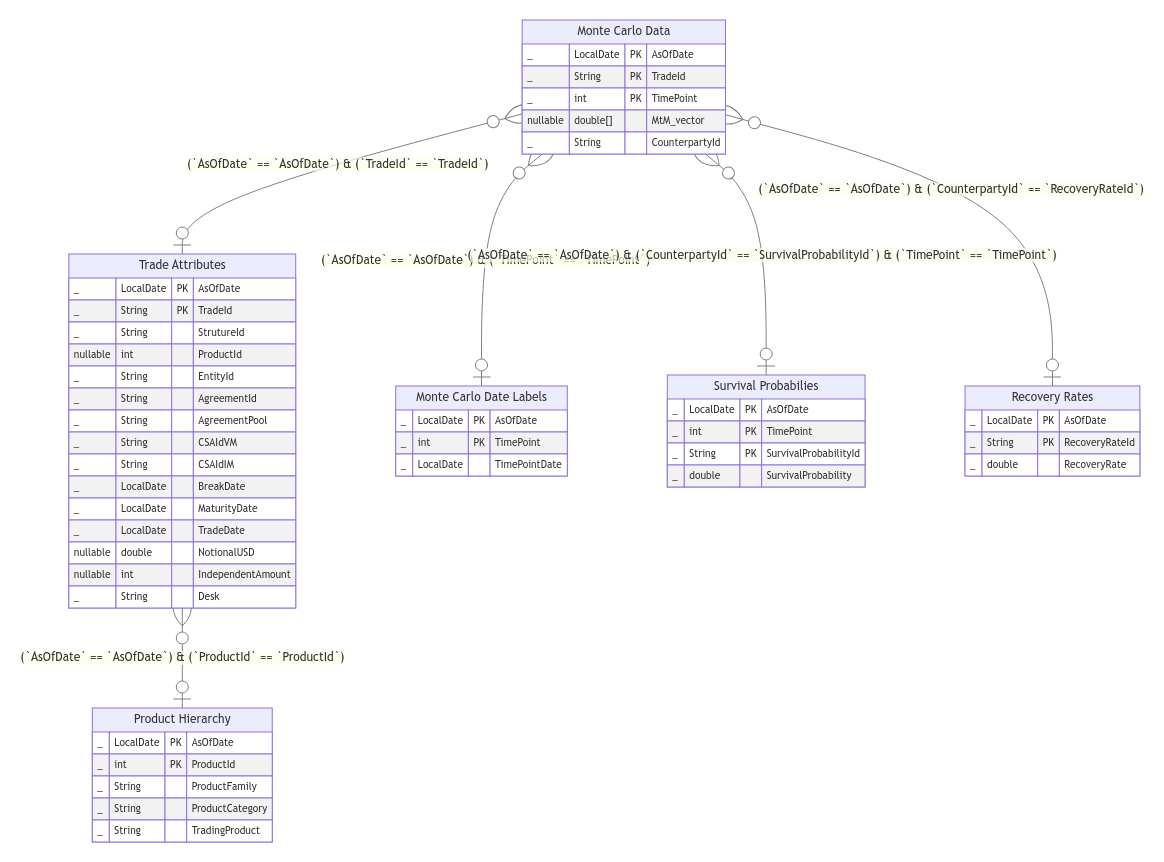

In [5]:
import atoti as tt
from urllib.parse import urlparse

# Starting atoti session
session = tt.Session.start(
    tt.SessionConfig(
        user_content_storage="content"
    )
)

url = session.url
port = urlparse(url).port

# URL of the UI:
print(f"http://localhost:{port}")

# Loading Monte Carlo data - vectors of simulated PL per trade and future time point
mc = session.read_csv(
    "data/monte-carlo-data.csv",
    keys=["AsOfDate", "TradeId", "TimePoint"],
    table_name="Monte Carlo Data",
    array_separator=";",
    data_types={"TimePoint": tt.type.INT, "AsOfDate": tt.type.LOCAL_DATE},
)

# Reading trade attributes
trd = session.read_csv(
    "data/trades-attributes.csv",
    keys=["AsOfDate", "TradeId"],
    table_name="Trade Attributes",
    data_types={
        "MaturityDate": tt.type.LOCAL_DATE,
        "BreakDate": tt.type.LOCAL_DATE,
        "AsOfDate": tt.type.LOCAL_DATE,
    },
)

# Reading future scenario date labels
sdt = session.read_csv(
    "data/simulation-dates.csv",
    keys=["AsOfDate", "TimePoint"],
    table_name="Monte Carlo Date Labels",
    data_types={"TimePointDate": tt.type.LOCAL_DATE, "AsOfDate": tt.type.LOCAL_DATE},
)

# Reading survival probabilities
sp = session.read_csv(
    "data/survival-probabilities.csv",
    keys=["AsOfDate", "TimePoint", "SurvivalProbabilityId"],
    table_name="Survival Probabilies",
    data_types={"AsOfDate": tt.type.LOCAL_DATE},
    default_values={"SurvivalProbability": 0.0},
)

# Reading recovery rates
rr = session.read_csv(
    "data/recovery-rates.csv",
    keys=["AsOfDate", "RecoveryRateId"],
    table_name="Recovery Rates",
    data_types={"AsOfDate": tt.type.LOCAL_DATE},
    default_values={"RecoveryRate": 0.0},
)


# Multi-level product taxonomy
prd = session.read_csv(
    "data/product-hierarchy.csv",
    keys=["AsOfDate", "ProductId"],
    table_name="Product Hierarchy",
    data_types={"AsOfDate": tt.type.LOCAL_DATE},
)


mc.join(trd)
mc.join(sdt)
mc.join(
    sp,
    (mc["CounterpartyId"] == sp["SurvivalProbabilityId"])
    & (mc["AsOfDate"] == sp["AsOfDate"])
    & (mc["TimePoint"] == sp["TimePoint"]),
)
mc.join(
    rr,
    (mc["CounterpartyId"] == rr["RecoveryRateId"]) & (mc["AsOfDate"] == rr["AsOfDate"]),
)
trd.join(prd)

cube = session.create_cube(mc, "Monte Carlo Analytics")
session.tables.schema

In [6]:
m, h, lvl = cube.measures, cube.hierarchies, cube.levels

In [7]:
h["AsOfDate"].slicing = True

# Monte Carlo aggregation example - UCVA

The standard formula for CVA aggregation is defined as follows (see 14.2 in the xVA challenge by John Gregory).

$$UCVA^{cpty} = -LGD^{cpty} \cdot \sum_{i=1}^{m}EE^{cpty}_{t_i}PD^{cpty}_{t_{i-1}, t_i}$$

The CVA formulae components:

- Loss given default (LGD) - this is the percentage amount of the exposure expected to be lost if the coutnerparty defaults. In our example we will compute LGD from recovery rates (RR): LGD = 100%-RR.
- Expected exposure (EE) - this is the discounted expected exposure for the future simulated dates given by $t_i$ for i = 1,m.
- Default probability - this term represents the marginal default probability in the interval between $t_{i-1}$ to $t_i$.

The formula must integrate over time and account for the distribution of EE and PD.

For a given time stamp and a counterparty expected exposure (EE) can be defined as follows.
$$EE^{cpty}_{t_i} = \frac{1}{N} \cdot \sum_{s=1}^{s=N} CE^{cpty, s}_{t_i}$$

Where credit exposure (CE) requires aggregation of MtM across trades for a given counterparty and scenario:

$$CE^{cpty, s}_{t_i} =max \left( \sum_{trd \in cpty}MtM^{trd, s}_{t_i},0 \right)$$

The input data provides us with trade-level vectors of simulated MtM for each future timepoint. When cube was created using `create_cube` command, Atoti has added a measure `MtM_vector.SUM` - 
which is MtM vectors summed up across trades. Let's use it to define Credit Exposure calculation per formula above.

To define the $max(\sum MtM, 0)$ calculation for each scenario, we'll apply Atoti's `array.positive_values` function on vector (see  in the [doc](https://docs.atoti.io/latest/lib/atoti.array.html#atoti.array.positive_values)):

In [8]:
m["CE"] = tt.array.positive_values(m["MtM_vector.SUM"])

I would like to enable this calculation only for each of the counterparties and for each of the future time points, I don't want CE to show anything across counterparties or across timepoints. So I am going to redefine `CE` measure as described below:

In [9]:
m["CE"] = tt.where(
    (~lvl["CounterpartyId"].isnull()) & (~lvl["TimePoint"].isnull()),
    tt.array.positive_values(m["MtM_vector.SUM"]),
)

The Expected Exposure is calculated as average credit exposure for each counterparty and time step:

In [10]:
m["EE"] = tt.where(
    (~lvl["CounterpartyId"].isnull()) & (~lvl["TimePoint"].isnull()),
    tt.array.mean(m["CE"]),
)

In [11]:
cube.query(m["EE"], m["CE"], levels=[lvl["CounterpartyId"], lvl["TimePoint"]])

EE  \
CounterpartyId                                     TimePoint             
Allegheny Energy                                   0               .00   
                                                   1               .00   
                                                   2              5.95   
                                                   3             21.14   
                                                   4             37.91   
...                                                                ...   
Vale R Doce-PNA (Companhia Vale do Rio Doce SA-... 5575       2,572.59   
                                                   5940       2,367.67   
                                                   6305       2,178.69   
                                                   6671       2,325.32   
                                                   7036       2,517.20   

                                                                                              CE  
CounterpartyId                                     TimePoint                                      
Allegheny Energy                                   0                doubleVector[1001]{0.0, ...}  
                                                   1                doubleVector[1001]{0.0, ...}  
                                                   2                doubleVector[1001]{0.0, ...}  
                                                   3                doubleVector[1001]{0.0, ...}  
                                                   4                doubleVector[1001]{0.0, ...}  
...                                                                                          ...  
Vale R Doce-PNA (Companhia Vale do Rio Doce SA-... 5575       doubleVector[1001]{6260.3503, ...}  
                                                   5940       doubleVector[1001]{5676.0047, ...}  
                                                   6305       doubleVector[1001]{9167.2411, ...}  
                                                   6671       doubleVector[1001]{5066.4937, ...}  
                                                   7036       doubleVector[1001]{6372.6462, ...}  

[4137 rows x 2 columns]

Survival probabilities (SP) are provided in the input data, we'll use them to obtain Default probabilities (PD) from time $t_0$ to $t_1$ as a difference between $SP_0$ and $SP_1$.

In [12]:
m["SP"] = tt.agg.single_value(sp["SurvivalProbability"])
m["Previous SP"] = tt.shift(m["SP"], h["TimePoint"], offset=-1)

m["SP"].formatter = "DOUBLE[0.00000000%]"
m["Previous SP"].formatter = "DOUBLE[0.00000000%]"

cube.query(
    m["SP"],
    m["Previous SP"],
    levels=[lvl["CounterpartyId"], lvl["TimePoint"], lvl["AsOfDate"]],
)

SP  \
CounterpartyId                                     TimePoint AsOfDate                    
Allegheny Energy                                   0         2020-09-08  100.00000000%   
                                                   1         2020-09-08   99.99980000%   
                                                   2         2020-09-08   99.99960000%   
                                                   3         2020-09-08   99.99920000%   
                                                   4         2020-09-08   99.99850001%   
...                                                                                ...   
Vale R Doce-PNA (Companhia Vale do Rio Doce SA-... 5575      2020-09-08   92.63827120%   
                                                   5940      2020-09-08   91.62656864%   
                                                   6305      2020-09-08   91.03667679%   
                                                   6671      2020-09-08   90.05976221%   
                                                   7036      2020-09-08   89.37827999%   

                                                                           Previous SP  
CounterpartyId                                     TimePoint AsOfDate                   
Allegheny Energy                                   0         2020-09-08                 
                                                   1         2020-09-08  100.00000000%  
                                                   2         2020-09-08   99.99980000%  
                                                   3         2020-09-08   99.99960000%  
                                                   4         2020-09-08   99.99920000%  
...                                                                                ...  
Vale R Doce-PNA (Companhia Vale do Rio Doce SA-... 5575      2020-09-08   93.47270201%  
                                                   5940      2020-09-08   92.63827120%  
                                                   6305      2020-09-08   91.62656864%  
                                                   6671      2020-09-08   91.03667679%  
                                                   7036      2020-09-08   90.05976221%  

[4137 rows x 2 columns]

Probabilities of default between two time points:

In [13]:
m["PD"] = tt.where(m["Previous SP"].isnull(), 0, m["Previous SP"] - m["SP"])
m["PD"].formatter = "DOUBLE[0.00000000%]"

cube.query(
    m["SP"],
    m["Previous SP"],
    m["PD"],
    levels=[lvl["AsOfDate"], lvl["CounterpartyId"], lvl["TimePoint"]],
    filter=lvl["CounterpartyId"] == "Mitsubishi Electric Co.",
)

SP    Previous SP  \
AsOfDate   CounterpartyId          TimePoint                                 
2020-09-08 Mitsubishi Electric Co. 0          100.00000000%                  
                                   1           99.99990000%  100.00000000%   
                                   2           99.99970000%   99.99990000%   
                                   3           99.99960000%   99.99970000%   
                                   4           99.99940000%   99.99960000%   
...                                                     ...            ...   
                                   7593        86.39133637%   86.65320235%   
                                   7968        85.91151889%   86.39133637%   
                                   8342        85.60670482%   85.91151889%   
                                   8717        85.19767598%   85.60670482%   
                                   9092        83.98744300%   85.19767598%   

                                                       PD  
AsOfDate   CounterpartyId          TimePoint               
2020-09-08 Mitsubishi Electric Co. 0          0.00000000%  
                                   1          0.00010000%  
                                   2          0.00020000%  
                                   3          0.00010000%  
                                   4          0.00020000%  
...                                                   ...  
                                   7593       0.26186598%  
                                   7968       0.47981748%  
                                   8342       0.30481407%  
                                   8717       0.40902884%  
                                   9092       1.21023299%  

[97 rows x 3 columns]

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
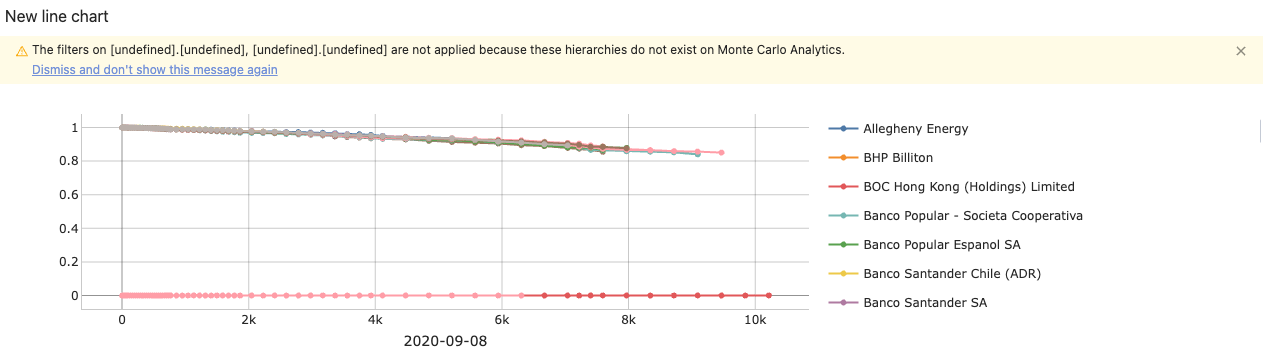

In [14]:
# Survival probabilities
session.widget

Recovery rates are provided for each counterpaty by the default simulation engine.

In [15]:
m["RR"] = tt.agg.single_value(rr["RecoveryRate"])
m["RR"].formatter = "DOUBLE[0.00%]"

In [16]:
m["LGD"] = 1 - m["RR"]

In [17]:
cube.query(
    m["RR"],
    m["LGD"],
    levels=[lvl["AsOfDate"], lvl["CounterpartyId"]],
    filter=lvl["CounterpartyId"] == "Mitsubishi Electric Co.",
)

,,RR,LGD
AsOfDate,CounterpartyId,,
2020-09-08,Mitsubishi Electric Co.,15.81%,.84


Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
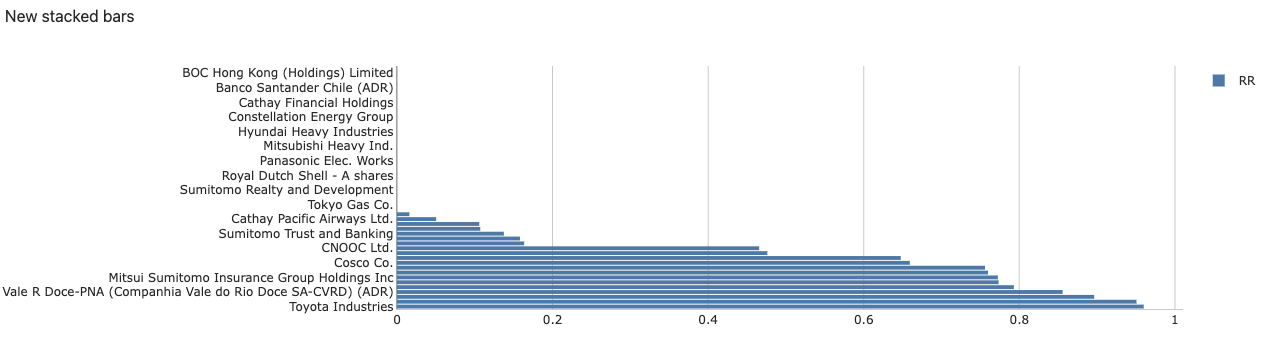

In [18]:
# Counterparties by RR
session.widget

In [19]:
m["EE x PD"] = m["EE"] * m["PD"]

Finally, the aggregation of the CVA for each individual counterparty across time points, and across counterparties is defined according to the formula

$$UCVA^{cpty} = -LGD^{cpty} \cdot \sum_{i=1}^{m}EE^{cpty}_{t_i}PD^{cpty}_{t_{i-1}, t_i}$$

In [20]:
m["CVA"] = tt.agg.sum(
    -m["LGD"]
    * tt.agg.sum(
        m["EE x PD"],  # m["EE"] * m["PD"],
        scope=tt.OriginScope({lvl["TimePoint"], lvl["CounterpartyId"]}),
    ),
    scope=tt.OriginScope({lvl["CounterpartyId"], lvl["AsOfDate"]}),
)
m["CVA"].formatter = "DOUBLE[0.00]"

In [21]:
cube.query(m["CVA"], levels=[lvl["CounterpartyId"]])

,CVA
CounterpartyId,
Allegheny Energy,-11.50
BHP Billiton,-0.00
BOC Hong Kong (Holdings) Limited,-0.00
Banco Popular - Societa Cooperativa,-0.00
Banco Popular Espanol SA,-0.00
Banco Santander Chile (ADR),-0.00
Banco Santander SA,-0.00
CNOOC Ltd.,-234.96
Carnival PLC,-0.00


Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
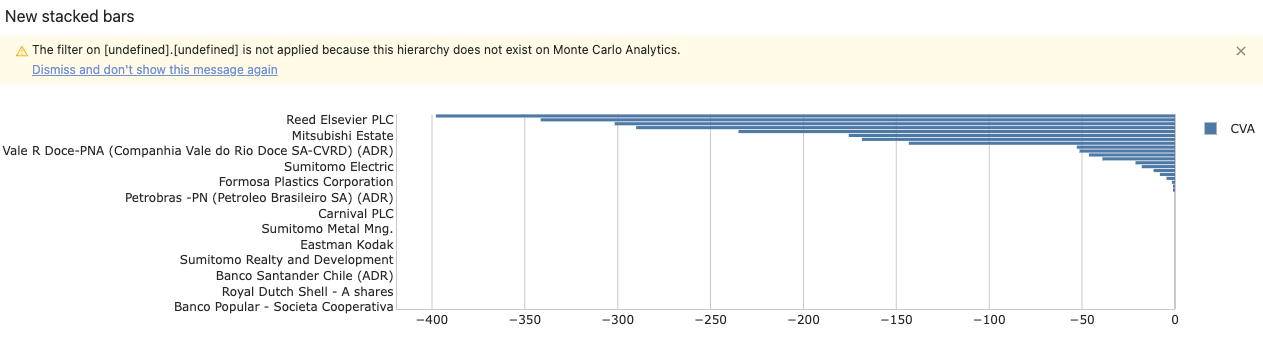

In [22]:
# Top-5 CVA drivers
session.widget

# Exposure measures and visualization

In this section let's create a few additional Exposure Measures - EPE, ENE, which are time-weighted positive and negative exposures. But let's start by looking at exposure data.

We've loaded simulated exposures as vectors. Each element in a vector corresponds to a simulation path. Let's visualize them. Let's first create a measure to access elements in a vector:

In [23]:
cube.create_parameter_hierarchy_from_members(
    "Scenarios",
    list(range(1001)),
    index_measure_name="Simulation Index",
)

m["MtM SUM at scenario"] = m["MtM_vector.SUM"][m["Simulation Index"]]

In [24]:
# Simulation paths for one of the trades (20 paths shown out of 1000)
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

In the CVA section we've create measures for:

- Credit exposures vector (CE),
- Expected Exposure (EE) - average credit exposure for each time point.

Let's create a few other exposure measures:

- Expected Positive Exposure (ENE) which is time weighted average of positive values across scenarios.
- Expected Negative Exposure (ENE) which is time weighted average of negative values across scenarios.
- Min Future Value, Max Future Value - smallest and larges simulated value. 

In [25]:
# Let's start by creating weights for each of the time periods

tw = session.read_csv(
    "data/time-weights.csv", table_name="Time-weights", keys=["TimePoint"], default_values={"TimePointWeight": 0.0}
)
mc.join(tw)
m["TimePointWeight"] = tt.agg.single_value(tw["TimePointWeight"])

In [26]:
ne = tt.where(
    (~lvl["CounterpartyId"].isnull()) & (~lvl["TimePoint"].isnull()),
    tt.array.mean(tt.array.negative_values(m["MtM_vector.SUM"])),
)

pe = tt.where(
    (~lvl["CounterpartyId"].isnull()) & (~lvl["TimePoint"].isnull()),
    tt.array.mean(tt.array.positive_values(m["MtM_vector.SUM"])),
)

m["ENE"] = tt.agg.sum(ne * m["TimePointWeight"], scope=tt.OriginScope({lvl["TimePoint"]}))
m["EPE"] = tt.agg.sum(pe * m["TimePointWeight"], scope=tt.OriginScope({lvl["TimePoint"]}))

In [27]:
# Approximation of Cpty Spread:
m["SpreadCounterparty"] = -m["CVA"] / m["EPE"]
m["SpreadCounterparty"].formatter = "DOUBLE[0.00000000%]"

In [28]:
cube.query(
    m["CVA"],
    m["EPE"],
    m["ENE"],
    m["SpreadCounterparty"],
    levels=[lvl["CounterpartyId"]],
)

,CVA,EPE,ENE,SpreadCounterparty
CounterpartyId,,,,
Allegheny Energy,-11.50,212.76,-829.50,5.40642596%
BHP Billiton,-0.00,253.58,-169.33,0.00000000%
BOC Hong Kong (Holdings) Limited,-0.00,660.21,-689.79,0.00000000%
Banco Popular - Societa Cooperativa,-0.00,688.05,"-1,155.03",0.00000000%
Banco Popular Espanol SA,-0.00,466.34,-377.91,0.00000000%
Banco Santander Chile (ADR),-0.00,"1,398.13",-271.46,0.00000000%
Banco Santander SA,-0.00,256.24,-160.82,0.00000000%
CNOOC Ltd.,-234.96,"1,623.85",-169.38,14.46947807%
Carnival PLC,-0.00,247.02,-366.47,0.00000000%


# Risk management measures - PFE calculation, ES and Peak Exposure

In this section we'll create "quantile"-type of aggregation of simulated exposures:

- Potential future exposure (PFE) - exposure which will be exceeded with a certain probability,
- Expected shortfall (ES) - expected exposure above PFE,
- Peak exposure (PE) - maximum expected shortfall across all time steps.

Lets start by creating a "parameter" simulation which will allow user changing the percentile for these measures.

In [29]:
confidence_levels = cube.create_parameter_simulation(
    "Confidence Levels", measures={"Confidence Level": 0.95}, base_scenario_name="0.95%"
)

confidence_levels += ("0.99%", 0.99)

In [30]:
# Confidence level in the "default" case
cube.query(m["Confidence Level"])

,Confidence Level
0,.95


In [31]:
# Confidence level when Confidence Levels parameter simulation is used and set to the desired scenario:
cube.query(m["Confidence Level"], filter=lvl["Confidence Levels"] == "0.99%")

,Confidence Level
0,.99


We'll define PFE as empirical quantile across simulated credit exposures vector.

Let's first visualize CE in a chart.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
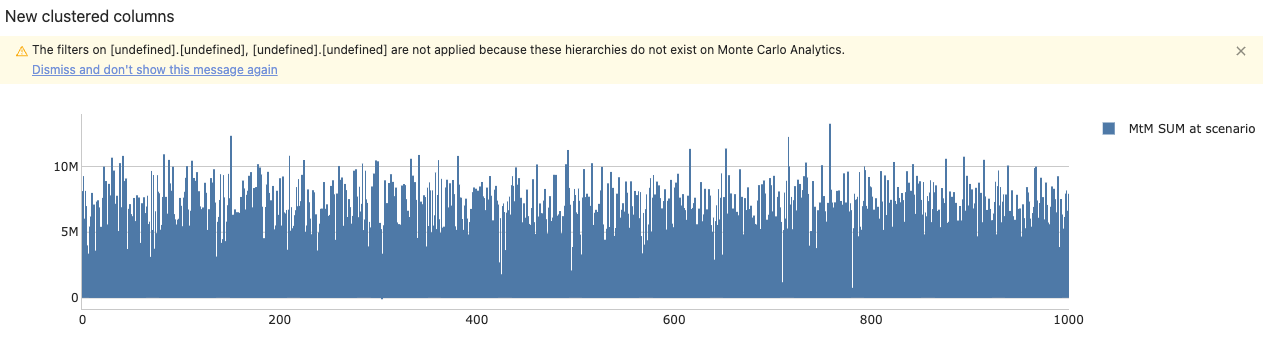

In [32]:
# This measure allows to access elements of the vector and visualize them in a pivot, chart, etc as scalar values
m["CE at scenario"] = m["CE"][m["Simulation Index"]]
# Simulated Exposure and Positive Exposure by Scenario for a future date
session.widget

In [33]:
m["PFE"] = tt.array.quantile(
    m["CE"], m["Confidence Level"], mode="centered", interpolation="higher"
)
m["PFE scenario"] = tt.array.quantile_index(
    m["CE"], m["Confidence Level"], mode="centered", interpolation="higher"
)

In [34]:
cube.query(
    m["PFE"],
    m["PFE scenario"],
    levels=[lvl["TimePoint"], lvl["CounterpartyId"]],
    filter=lvl["CounterpartyId"] == "Mitsubishi Electric Co.",
)

,,PFE,PFE scenario
TimePoint,CounterpartyId,,
0,Mitsubishi Electric Co.,"2,274.31",0
1,Mitsubishi Electric Co.,"3,496.31",987
2,Mitsubishi Electric Co.,"3,969.99",418
3,Mitsubishi Electric Co.,"4,372.19",953
4,Mitsubishi Electric Co.,"4,554.90",440
...,...,...,...
7593,Mitsubishi Electric Co.,"9,101.55",228
7968,Mitsubishi Electric Co.,"8,146.08",597
8342,Mitsubishi Electric Co.,"7,309.65",36


Let's create a measure that will return PFE in 1Y. The nearest scenario to 1 year in our data set is TimePoint 254:

In [35]:
m["PFE 1Y"] = tt.agg.sum(
    tt.filter(m["PFE"], lvl["TimePoint"] == 254),
    scope=tt.OriginScope({lvl["TimePoint"], lvl["CounterpartyId"]}),
)

To compute the Expected shortfall, we need to take credit exposures above PFE and take average. To compute the number of elements above PFE we'll use `Confidence level`

In [36]:
m["Number of Tail Exposures"] = tt.math.floor(
    (1 - m["Confidence Level"]) * tt.array.len(m["MtM_vector.SUM"])
)
m["ES"] = tt.array.mean(tt.array.n_greatest(m["CE"], m["Number of Tail Exposures"]))

In [37]:
cube.query(
    m["PFE"],
    m["ES"],
    levels=[lvl["TimePoint"], lvl["CounterpartyId"]],
    filter=lvl["CounterpartyId"] == "Mitsubishi Electric Co.",
)

,,PFE,ES
TimePoint,CounterpartyId,,
0,Mitsubishi Electric Co.,"2,274.31","2,274.31"
1,Mitsubishi Electric Co.,"3,496.31","3,869.61"
2,Mitsubishi Electric Co.,"3,969.99","4,399.22"
3,Mitsubishi Electric Co.,"4,372.19","4,866.95"
4,Mitsubishi Electric Co.,"4,554.90","5,171.38"
...,...,...,...
7593,Mitsubishi Electric Co.,"9,101.55","10,634.89"
7968,Mitsubishi Electric Co.,"8,146.08","9,706.80"
8342,Mitsubishi Electric Co.,"7,309.65","8,766.45"


Finally, let's define peak exposure (PE) - by aggregating ES over time points:

In [38]:
m["PE"] = tt.agg.max(m["ES"], scope=tt.OriginScope({lvl["TimePoint"]}))

Let's also re-define PE so that it's a summation across counterparties:

In [39]:
m["PE"] = tt.agg.sum(
    tt.agg.max(m["ES"], scope=tt.OriginScope({lvl["TimePoint"]})),
    scope=tt.OriginScope({lvl["CounterpartyId"]}),
)

In [40]:
cube.query(
    m["PE"],
    m["EPE"],
    levels=[lvl["CounterpartyId"]],
    filter=lvl["CounterpartyId"] == "Mitsubishi Electric Co.",
)

,PE,EPE
CounterpartyId,,
Mitsubishi Electric Co.,"15,728.88","1,511.59"


In [41]:
m["Min Future Value"] = tt.where(
    (~lvl["CounterpartyId"].isnull()) & (~lvl["TimePoint"].isnull()),
    tt.array.min(m["MtM_vector.SUM"]),
)
m["Max Future Value"] = tt.where(
    (~lvl["CounterpartyId"].isnull()) & (~lvl["TimePoint"].isnull()),
    tt.array.max(m["MtM_vector.SUM"]),
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
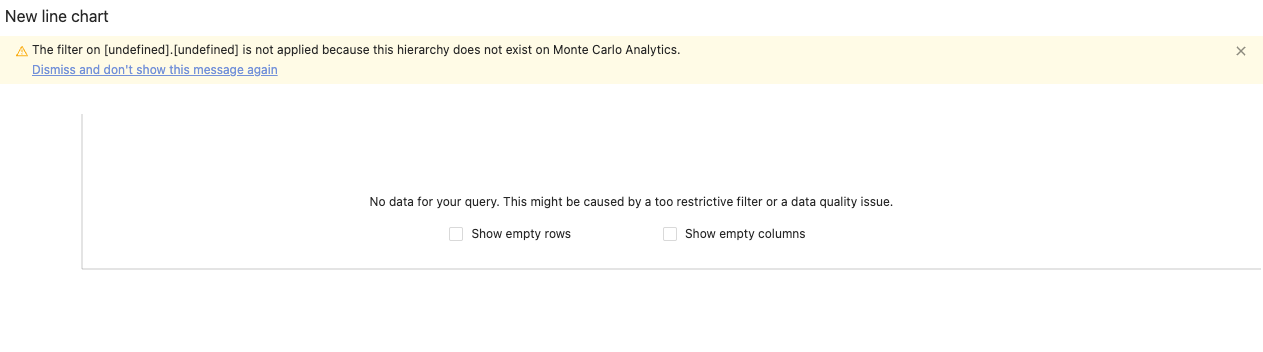

In [42]:
# Simulated Credit Exposure by Scenario for a counterparty and a future date
session.widget

Remember we've created a parameter for the Confidence level? Let's see how PE and other risk measures change as we change the confidence level.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
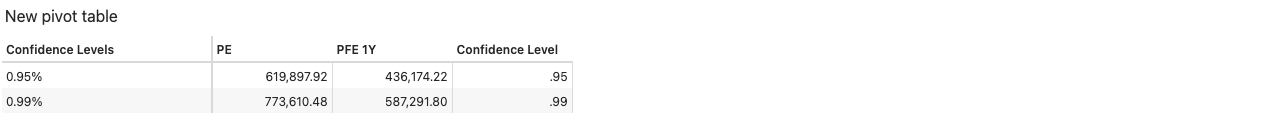

In [43]:
# Peak Exposure and PFE under different confidence levels
session.widget

In [44]:
m["PFE Sum"] = tt.agg.sum(m["PFE"], scope=tt.OriginScope({lvl["CounterpartyId"]}))

# Risk mitigants 

Let's enhance the exposure calculation by including a risk mitigant. 

In this section we'll see how to include "Trade Break Dates". Other examples of risk mitigants could include - Collateral Model, guarantees, options and other.

To compare calculations with and without risk mitigants side by side, let's create a hierarchy.

## Trade break dates

Trade break dates are configured on trade level (if any) and can be included into the exposure model as a risk mitigant as follows:

if scenario date is before or on Trade break date, then CE = max(MtM, 0) as usual.
if scenario date is after Trade break date, then we assume we can exit the trade, hence CE = 0.

So far, Credit Exposure has been defined simply as: 

`m["CE"] = tt.array.positive_values(m["MtM_vector.SUM"])`

To include trade break dates, we'll need to check for each Trade break date (if exist) and each time point, that time point is before trade break date.

In [45]:
m["Filtered MtM_vector.SUM"] = tt.where(
    lvl["TimePointDate"] <= lvl["BreakDate"], m["MtM_vector.SUM"]
)

m["CE with BreakDates"] = tt.agg.sum(
    tt.where(
        (~lvl["CounterpartyId"].isnull()) & (~lvl["TimePoint"].isnull()),
        tt.array.positive_values(m["Filtered MtM_vector.SUM"]),
    ),
    scope=tt.OriginScope({lvl["BreakDate"], lvl["TimePointDate"]}),
)

In [46]:
cube.create_parameter_hierarchy_from_members(
    "TypeofRiskMitigant", ["No Risk Mitigant", "Trade Break Date"]
)

Instead of using `where` clause to create the measure conditionally, we could use the `atoti.switch` statement instead.  

```python
m["EE"] = tt.where(
    lvl["TypeofRiskMitigant"] == "No Risk Mitigant",
    tt.array.mean(m["CE"]),
    tt.where(
        lvl["TypeofRiskMitigant"] == "Trade Break Date",
        tt.array.mean(m["CE with BreakDates"]),
    ),
)
```
Below is the `switch` equivalent of the `where` computation above. 

In [47]:
m["EE"] = tt.switch(
    lvl["TypeofRiskMitigant"],
    {
        "No Risk Mitigant": tt.array.mean(m["CE"]),
        "Trade Break Date": tt.array.mean(m["CE with BreakDates"]),
    },
)

In [48]:
cube.query(
    m["EE"],
    levels=[
        lvl["CounterpartyId"],
        lvl["TimePoint"],
        lvl["TimePointDate"],
        lvl["BreakDate"],
        lvl["TypeofRiskMitigant"],
    ],
    filter=lvl["CounterpartyId"] == "Mitsubishi Electric Co.",
)

EE
CounterpartyId          TimePoint TimePointDate BreakDate  TypeofRiskMitigant          
Mitsubishi Electric Co. 0         2020-09-08    2030-09-18 No Risk Mitigant      852.41
                                                           Trade Break Date      852.41
                                                2037-04-27 No Risk Mitigant    1,421.90
                                                           Trade Break Date    1,421.90
                        1         2020-09-09    2030-09-18 No Risk Mitigant      886.43
...                                                                                 ...
                        7593      2041-06-23    2037-04-27 No Risk Mitigant    2,752.52
                        7968      2042-07-03    2037-04-27 No Risk Mitigant    2,584.93
                        8342      2043-07-12    2037-04-27 No Risk Mitigant    2,327.64
                        8717      2044-07-21    2037-04-27 No Risk Mitigant    2,615.47
                        9092      2045-07-31    2037-04-27 No Risk Mitigant    2,702.23

[346 rows x 1 columns]

In [49]:
cube.query(
    m["CVA"],
    levels=[lvl["CounterpartyId"], lvl["TypeofRiskMitigant"], lvl["AsOfDate"]],
    filter=lvl["CounterpartyId"] == "Mitsubishi Electric Co.",
)

CVA
CounterpartyId          TypeofRiskMitigant AsOfDate           
Mitsubishi Electric Co. No Risk Mitigant   2020-09-08  -397.83
                        Trade Break Date   2020-09-08  -276.97

# DVA approximation

Let's approximate DVA using spreads for Legal Entities, ENE and formula:

$$DVA_p = - ENE_p \cdot Spread_p$$ 

In [50]:
# Sourcing spreads
spr_p = session.read_csv(
    "data/spreads-party.csv", keys=["AsOfDate", "EntityId"], table_name="Credit Spreads"
)
trd.join(spr_p)

In [51]:
m["SpreadParty"] = tt.agg.single_value(spr_p["SpreadParty"])

In [52]:
m["DVA"] = tt.agg.sum(
    -m["ENE"] * m["SpreadParty"],
    scope=tt.OriginScope({lvl["EntityId"], lvl["CounterpartyId"]}),
)
cube.query(m["DVA"], include_totals=True, levels=[lvl["CounterpartyId"]])

,DVA
CounterpartyId,
Total,611.39
Allegheny Energy,16.59
BHP Billiton,3.39
BOC Hong Kong (Holdings) Limited,13.80
Banco Popular - Societa Cooperativa,23.10
Banco Popular Espanol SA,22.67
Banco Santander Chile (ADR),5.43
Banco Santander SA,3.22
CNOOC Ltd.,3.39


# Valuation Components

In [53]:
initial_mtm = tt.filter(m["MtM_vector.SUM"], lvl["TimePoint"] == 0)
m["Risk-free value"] = initial_mtm[0]
cube.query(m["Risk-free value"])

,Risk-free value
0,"79,152.29"


In [54]:
m["Risky Value"] = m["Risk-free value"] + m["CVA"] + m["DVA"]

In [55]:
# Creating a measure that we can break down into components - risk-free value, CVA, and DVA

cube.create_parameter_hierarchy_from_members(
    "Valuation Components", ["Risk-free value", "CVA", "DVA"]
)

m["Value Components"] = tt.where(
    lvl["Valuation Components"] == "Risk-free value",
    m["Risk-free value"],
    tt.where(
        lvl["Valuation Components"] == "CVA",
        m["CVA"],
        tt.where(
            lvl["Valuation Components"] == "DVA",
            m["DVA"],
        ),
    ),
)

In [56]:
lvl["Valuation Components"].order = tt.CustomOrder(
    first_elements=["Risk-free value", "CVA", "DVA"]
)

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
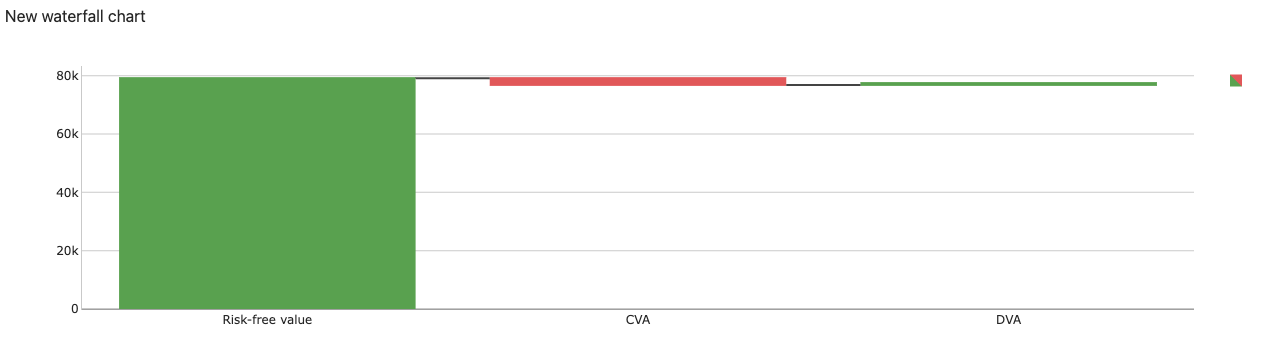

In [57]:
session.widget

# Limits

In [59]:
lm = session.read_csv(
    "data/limits.csv", table_name="Limits", keys=["CounterpartyId"]
)  # , default_values={"CounterpartyId": ""})
mc.join(lm, (mc["CounterpartyId"] == lm["CounterpartyId"]))

In [60]:
m["PFE Limit"] = tt.agg.single_value(lm["PFE Limit"])

In [61]:
m["Breaches Status"] = tt.where(m["PFE 1Y"] > m["PFE Limit"], "🔺", "🟢")

In [64]:
session.link / "#/dashboard/dba"

http://localhost:63193/#/dashboard/dba

# Real-time trades feed

Launch the Limit dashboard from the URL above. Uncomment the below code snippet and execute to see how the limits monitor behaves with the incoming data.

In [65]:
# import time
# for f in os.listdir("what-if"):
#     if f.endswith(".csv"):
#         mc.load_csv("what-if/"+f, array_separator=";")
#         time.sleep(0.5)

# What-If and Pre-deal simulations

As all the measures we defined so far are reaggregated each time user runs the query, he or she can use filters to exclude one or several positions for ad-hoc analysis and see updated metrics.

In addition to that new hypothetical trades priced by the risk engine can be submitted into Atoti to evaluate "what-if scenarios". 

In this section let's simulate the impact of a new trade by including it in each of the netting sets (counterparty).

In [67]:
import pandas as pd

df = pd.read_csv("data/what-if-trade.csv")

cpties = """Mitsubishi Electric Co.
Cathay Pacific Airways Ltd.
HSBC Holdings plc"""

for c in cpties.split("\n"):
    print(c)
    df["CounterpartyId"] = c
    df.to_csv("data/what-if-trade.csv", index=False)
    mc.scenarios["What-if " + c].load(tt.CsvLoad("data/what-if-trade.csv", array_separator=";"))

Mitsubishi Electric Co.
Cathay Pacific Airways Ltd.
HSBC Holdings plc


Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
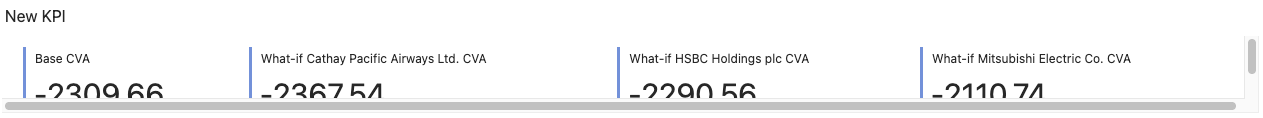

In [68]:
session.widget

# Loading previous day

In [70]:
mc.load(tt.CsvLoad("data-prev/monte-carlo-data.csv", array_separator=";"))
session.tables["Trade Attributes"].load(tt.CsvLoad("data-prev/trades-attributes.csv"))
rr.load(tt.CsvLoad("data-prev/recovery-rates.csv"))
sp.load(tt.CsvLoad("data-prev/survival-probabilities.csv"))
sdt.load(tt.CsvLoad("data-prev/simulation-dates.csv"))
spr_p.load(tt.CsvLoad("data-prev/spreads-party.csv"))
lm.load(tt.CsvLoad("data/limits.csv"))

# URL

In [71]:
session.link / "#/dashboard/c4a"

http://localhost:63193/#/dashboard/c4a

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=github-xva" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>